In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data = pd.read_csv("Data.csv")
data["day_tick"] = data["day"] + data["tick"]
data = data.sort_values(by='day_tick')
data = data.set_index("day_tick")
data.head()

,day,tick,logprice
day_tick,,,
1.018120,1,0.018120,4.430221
1.018162,1,0.018162,4.430698
1.018205,1,0.018205,4.431174
1.018248,1,0.018248,4.431174
1.018291,1,0.018291,4.431055


In [ ]:
inst_returns = data["logprice"] - data["logprice"].shift(1)
inst_returns.head()

day_tick
1.018120         NaN
1.018162    0.000476
1.018205    0.000476
1.018248    0.000000
1.018291   -0.000119
Name: logprice, dtype: float64

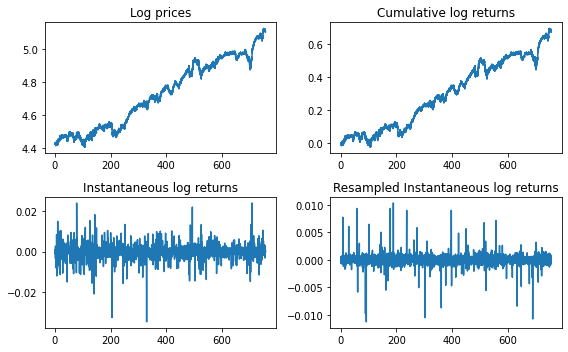

In [5]:
_, axs = plt.subplots(2,2,figsize=(8,5))

axs[0,0].plot(data["logprice"])
axs[0,0].set_title("Log prices")

axs[0,1].plot((data["logprice"] - data["logprice"].iloc[0]))
axs[0,1].set_title("Cumulative log returns")

axs[1,0].plot(inst_returns)
axs[1,0].set_title("Instantaneous log returns")

axs[1,1].plot(inst_returns.iloc[2::10])
axs[1,1].set_title("Resampled Instantaneous log returns")

plt.tight_layout()

In [6]:
data.shape[0] / (data["day"].unique().shape[0] + 1)

2048.2953642384105

In [7]:
inst_returns.describe()

count    1.546462e+06
mean     4.344354e-07
std      2.064500e-04
min     -3.442275e-02
25%     -8.505209e-05
50%      0.000000e+00
75%      8.495094e-05
max      2.381488e-02
Name: logprice, dtype: float64

# Set equally spaced returns

In [8]:
# First, create a copy of the original dataframe to keep it intact
data_equal = data.copy().reset_index()

# Use the number of minutes in a day to compute it, so we have one price per minute
minutes_day = 24 * 60

# Define a common equally spaced tick grid using the number of minutes in a day
common_ticks = np.linspace(data_equal['tick'].min(), data_equal['tick'].max(), minutes_day)

# Initialize an empty list to store the results
days_interpolated = []

# Loop over each unique day
for day in data_equal['day'].unique():

    # Filter the data for the current day
    day_data = data_equal[data_equal['day'] == day].copy()

    # Interpolate 'logprice' for the common tick grid
    interpolated_prices = np.interp(common_ticks, day_data['tick'], day_data['logprice'])

    # Create a new dataframe for this day with the common ticks and interpolated prices
    day_interpolated = pd.DataFrame({
        'day': day,
        'tick': common_ticks,
        'logprice': interpolated_prices
    })

    # Append the interpolated data to the result list
    days_interpolated.append(day_interpolated)

# Concatenate all days into a single DataFrame
df_interpolated = pd.concat(days_interpolated, ignore_index=True)

# Create a unique identifier for each row using 'day' and 'tick'
df_interpolated["day_tick"] = df_interpolated["day"] + df_interpolated["tick"]

# Now, df_interpolated contains the equally spaced ticks and interpolated prices for each day


We need to get only the data starting in the starting point of the original dataset, so we don't backfill the logprice for the first day

In [9]:
df_interpolated = df_interpolated[df_interpolated.day_tick >= data.index[0]].reset_index(drop=True)

In [10]:
df_interpolated

,day,tick,logprice,day_tick
0,1,0.018805,4.430178,1.018805
1,1,0.019500,4.430755,1.019500
2,1,0.020195,4.430030,1.020195
3,1,0.020890,4.430620,1.020890
4,1,0.021585,4.430702,1.021585
...,...,...,...,...
1085728,754,0.997220,5.102607,754.997220
1085729,754,0.997915,5.102483,754.997915
1085730,754,0.998610,5.102030,754.998610
1085731,754,0.999305,5.101117,754.999305


# Handling 0s

Our approach: Fill them with NaN values and then linearly interpolate them

In [11]:
data_clean = df_interpolated.copy()
data_clean.loc[((data_clean["logprice"] - data_clean["logprice"].shift(1)) == 0).values,"logprice"] = np.nan

data_clean["logprice"] = data_clean["logprice"].interpolate(x=data_clean['day_tick'])

data_clean["log_returns"] = data_clean["logprice"] - data_clean["logprice"].shift(1)

data_clean = data_clean[data_clean.log_returns!=0]

<AxesSubplot: >

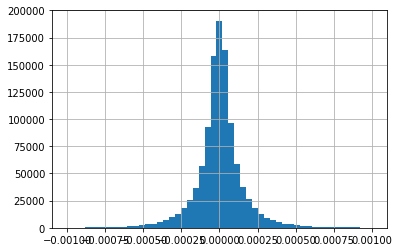

In [12]:
data_clean[data_clean.log_returns.abs() < 0.001].log_returns.hist(bins=51)

In [13]:
data_clean["log_returns"].describe()

count    1.085721e+06
mean     6.188345e-07
std      2.227824e-04
min     -3.442275e-02
25%     -6.291367e-05
50%      1.285709e-06
75%      6.505355e-05
max      2.381488e-02
Name: log_returns, dtype: float64

Note that the mean has changed here because we have reduced the number of elements when setting the equally spaced grid.

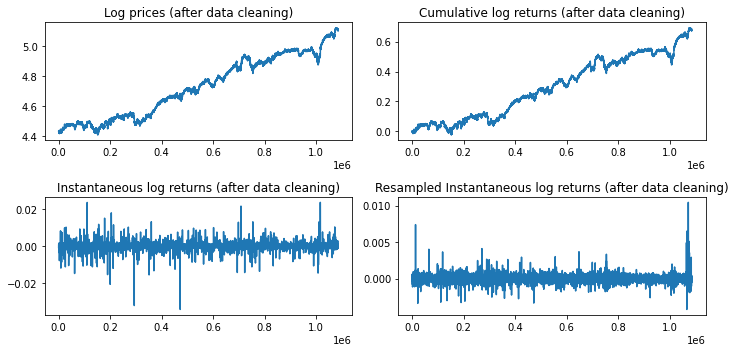

In [14]:
_, axs = plt.subplots(2,2,figsize=(10,5))

axs[0,0].plot(data_clean["logprice"])
axs[0,0].set_title("Log prices (after data cleaning)")

axs[0,1].plot((data_clean["logprice"] - data_clean["logprice"].iloc[0]))
axs[0,1].set_title("Cumulative log returns (after data cleaning)")

axs[1,0].plot(data_clean["log_returns"])
axs[1,0].set_title("Instantaneous log returns (after data cleaning)")

axs[1,1].plot(data_clean["log_returns"].iloc[2::10])
axs[1,1].set_title("Resampled Instantaneous log returns (after data cleaning)")

plt.tight_layout()

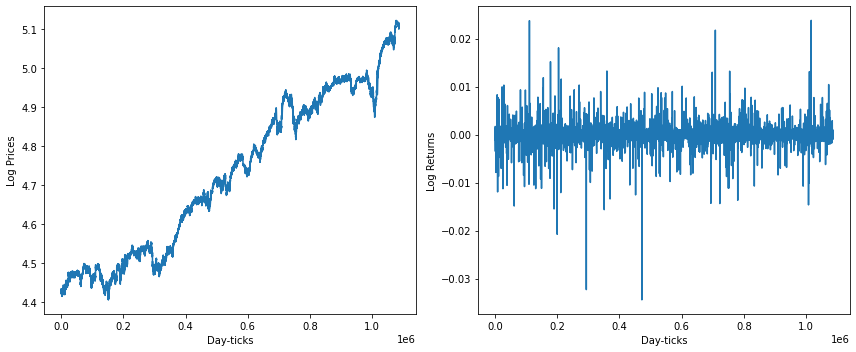

In [15]:
_, axs = plt.subplots(1,2,figsize=(12,5))

axs[0].plot(data_clean["logprice"])
# axs[0].set_title("Log prices (after data cleaning)")
axs[0].set_xlabel("Day-ticks")
axs[0].set_ylabel("Log Prices")
axs[1].plot(data_clean["log_returns"])
# axs[1].set_title("Instantaneous log returns (after data cleaning)")
axs[1].set_xlabel("Day-ticks")
axs[1].set_ylabel("Log Returns")
plt.tight_layout()
plt.savefig("Prices_returns.png")

In [16]:
data_clean.sort_values(by="log_returns")

,day,tick,logprice,day_tick,log_returns
472293,329,0.000043,4.646504,329.000043,-0.034423
293733,205,0.000043,4.495132,205.000043,-0.032293
200133,140,0.000043,4.479153,140.000043,-0.020767
351333,245,0.000043,4.528775,245.000043,-0.015636
190053,133,0.000043,4.460144,133.000043,-0.015486
...,...,...,...,...,...
204453,143,0.000043,4.503470,143.000043,0.018097
708453,493,0.000043,4.871143,493.000043,0.021773
110853,78,0.000043,4.491385,78.000043,0.023755
1016613,707,0.000043,4.958289,707.000043,0.023815


# Box-plot for evey 60 days

<AxesSubplot: xlabel='period', ylabel='log_returns'>

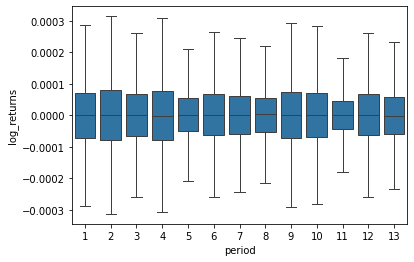

In [17]:
# Assign a period number to each 60-day block
data_clean['period'] = data_clean['day'] // 60 + 1

sns.boxplot(x='period', y='log_returns', data=data_clean, showfliers=False) # Hide the outliers for a more clear view

In [18]:
# data_clean.drop(columns="period").to_csv("data_clean.csv")